In [15]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms, datasets    # MNIST

''' 2. is_available () : accelerating hardware? '''
if torch.cuda.is_available ():
    DEVICE = torch.device ('cuda')
else:
    DEVICE = torch.device ('cpu')

print ('Using PyTorch version: ', torch.__version__, ' Device: ', DEVICE)

BATCH_SIZE = 32
EPOCHS = 10

''' 3. MNIST data download + split data into Train set and Test set '''
train_dataset = datasets.MNIST (root = "../data/MNIST", train = True, download = True,
                                transform = transforms.ToTensor ())
test_dataset = datasets.MNIST (root = "../data/MNIST", train = False,
                                transform = transforms.ToTensor ())

train_loader = torch.utils.data.DataLoader (dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)
test_loader = torch.utils.data.DataLoader (dataset = test_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = False)



Using PyTorch version:  1.11.0+cu102  Device:  cuda


X_train:  torch.Size([32, 1, 28, 28]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor


' 6. MLP model design '

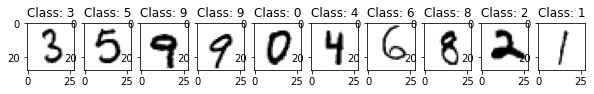

In [16]:
''' 4. Check the data '''
for (X_train, y_train) in train_loader:
    print ('X_train: ', X_train.size (), 'type: ', X_train.type ())
    print ('y_train: ', y_train.size (), 'type: ', y_train.type ())
    break   # end of the loop.

''' 5. Check the data '''
pltsize = 1
plt.figure (figsize = (10 * pltsize, pltsize))

for i in range (10):
    plt.subplot (1, 10, i + 1)
    plt.axis ('on')
    plt.imshow (X_train[i, :, :, :].numpy ().reshape (28, 28), cmap = "gray_r")
    plt.title ('Class: ' + str (y_train[i].item ()))

''' 6. MLP model design '''

In [17]:
''' 6. MLP model design '''
class Net (nn.Module):
    def __init__ (self):
        super (Net, self).__init__()
        self.fc1 = nn.Linear (28 * 28, 512)
        self.fc2 = nn.Linear (512, 256)
        self.fc3 = nn.Linear (256, 10)
        self.dropout_prob = 0.5

    def forward (self, x):
        x = x.view (-1, 28 * 28)
        x = self.fc1 (x)
        x = F.relu (x)
        x = F.dropout (x, training = self.training, p = self.dropout_prob)

        x = self.fc2 (x)
        x = F.relu (x)
        x = F.dropout (x, training = self.training, p = self.dropout_prob)

        x = self.fc3 (x)
        x = F.log_softmax (x, dim = 1)
        
        return x

''' 7. Optimizer, Objective Function setting '''
model = Net ().to (DEVICE)
optimizer = torch.optim.SGD (model.parameters (), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss ()

print (model)
print (type(model))

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
<class '__main__.Net'>


In [18]:
''' 8. MLP training, checking the accuracy '''
def train (model, train_loader, optimizer, log_interval):
    model.train ()
    
    for batch_idx, (image, label) in enumerate (train_loader):
        image = image.to (DEVICE)
        label = label.to (DEVICE)
        
        optimizer.zero_grad ()      # clear the gradient used prior

        output = model (image)              # forward pass
        loss = criterion (output, label)    # CrossEntropy: calculating the loss value

        loss.backward ()    # apply the gradient for each parameter
        optimizer.step ()   # weight update using the gradient

        if batch_idx % log_interval == 0:
            print ("Train Epoch: {} [{}/{}({:.0f}%)]\t Train Loss: {:.6f}".format(Epoch, batch_idx * len(image),
                    len (train_loader.dataset), 100. * batch_idx / len (train_loader), loss.item ()))


In [19]:
''' 9. Evaluating during training '''
def evaluate (model, test_loader):
    model.eval ()
    test_loss = 0
    correct = 0

    with torch.no_grad ():
        for image, label in test_loader:
            image = image.to (DEVICE)
            label = label.to (DEVICE)

            output = model (image)

            test_loss += criterion (output, label).item ()
            prediction = output.max (1, keepdim = True) [1]
            correct += prediction.eq (label.view_as (prediction)).sum ().item ()

    test_loss /= len (test_loader.dataset)
    test_accuracy = 100. * correct / len (test_loader.dataset)
    return test_loss, test_accuracy

In [20]:
''' 10. MLP training '''
for Epoch in range (1, EPOCHS + 1):
    train (model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate (model, test_loader)
    print ("\n[EPOCH: {}], \t Test Loss: {:.4f}, \t Test Accuracy: {:.2f} % \n".format (Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000(0%)]	 Train Loss: 2.503881


/home/ycho/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [6400/60000(11%)]	 Train Loss: 2.365476
Train Epoch: 1 [12800/60000(21%)]	 Train Loss: 2.330354
Train Epoch: 1 [19200/60000(32%)]	 Train Loss: 2.335601
Train Epoch: 1 [25600/60000(43%)]	 Train Loss: 2.368753
Train Epoch: 1 [32000/60000(53%)]	 Train Loss: 2.286512
Train Epoch: 1 [38400/60000(64%)]	 Train Loss: 2.355856
Train Epoch: 1 [44800/60000(75%)]	 Train Loss: 2.373369
Train Epoch: 1 [51200/60000(85%)]	 Train Loss: 2.269764
Train Epoch: 1 [57600/60000(96%)]	 Train Loss: 2.310197

[EPOCH: 1], 	 Test Loss: 0.0714, 	 Test Accuracy: 19.41 % 

Train Epoch: 2 [0/60000(0%)]	 Train Loss: 2.322386
Train Epoch: 2 [6400/60000(11%)]	 Train Loss: 2.293953
Train Epoch: 2 [12800/60000(21%)]	 Train Loss: 2.197116
Train Epoch: 2 [19200/60000(32%)]	 Train Loss: 2.326995
Train Epoch: 2 [25600/60000(43%)]	 Train Loss: 2.228576
Train Epoch: 2 [32000/60000(53%)]	 Train Loss: 2.220186
Train Epoch: 2 [38400/60000(64%)]	 Train Loss: 2.323701
Train Epoch: 2 [44800/60000(75%)]	 Train Loss: 2.1